In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
# from pymodulon.enrichment import *
from sklearn.metrics import jaccard_score
from scipy.stats import spearmanr
import re
from pymodulon.enrichment import compute_regulon_enrichment
from pymodulon.enrichment import parse_regulon_str

In [2]:
# p1k data
p1k_A = pd.read_csv('../data/p1k/A.csv', index_col=0)
p1k_M = pd.read_csv('../data/p1k/M.csv', index_col=0)
imodulon_table = pd.read_csv('../data/p1k/iM_table.csv', index_col=1)
p1k_genes = pd.read_csv('../data/p1k/gene_info.csv', index_col=0)
p1k_genes.index.name = 'locus'
sample_data = pd.read_csv('../data/p1k/sample_table.csv', index_col=0)
p1k_X = pd.read_csv('../data/p1k/log_tpm.csv', index_col=0)

p1k_A.index = imodulon_table.index
p1k_M.columns = imodulon_table.index

p1k_gene_presence = pd.read_csv('../data/p1k/gene_presence_matrix.csv', index_col=0).astype(int)
p1k_gene_presence.columns = imodulon_table.index

trn_p1k = pd.read_csv('../data/p1k/trn.csv', index_col=0)

In [3]:
# NCA Results full trn
NCA_A = pd.read_csv('../data/NCA/full_trn/NCA_Activity.csv', index_col=0)
NCA_gene_presence = pd.read_csv('../data/NCA/full_trn/NCA_A_TRN.csv', index_col=0)

gene_mapping = pd.read_csv('../data/p1k/Gene-Name-from-All-genes-of-E.-coli-K-12-substr.-MG1655.txt', sep='\t')
gene_mapping.columns = ['gene_names', 'locus', 'synonyms']
gene_mapping = gene_mapping.replace({'phnE1':'phnE', 'lfgA':'yfjX', 'lfgB':'yfjY', 'lptM':'yifL'})
gene_mapping = gene_mapping[gene_mapping.locus.isin(p1k_genes.index)]

def get_locus_tag(gene_name):
    if gene_name in gene_mapping.gene_names.values:
        return gene_mapping.reset_index().set_index('gene_names').loc[gene_name, 'locus']
    else: # one edge case, gene ruled pseudogene
        return 'b3681'

# NCA_gene_presence.index = [p1k_genes.reset_index().set_index('gene_name').loc[x, 'locus'] for x in NCA_gene_presence.index]
# NCA_gene_presence = NCA_gene_presence.reindex(p1k_gene_presence.index, fill_value=0)
NCA_gene_presence.index.name = 'gene_name'
NCA_gene_presence = NCA_gene_presence.reset_index()
NCA_gene_presence['locus'] = NCA_gene_presence.gene_name.apply(lambda x: get_locus_tag(x))
NCA_gene_presence = NCA_gene_presence.set_index('locus')
NCA_gene_presence = NCA_gene_presence.drop('gene_name', axis=1).astype(int)

# trn_test = NCA_gene_presence
# trn_test = trn_test.T.rename_axis('Source')\
#   .reset_index()\
#   .melt('Source', value_name='Weight', var_name='Target')\
#   .query('Source != Target')\
#   .reset_index(drop=True)
# trn_test = trn_test.drop(trn_test[trn_test.Weight == 0].index)
# trn_test.columns = ['regulator','gene_id','effect']
# trn = trn_test


In [4]:
# decouler results
dc_A = pd.read_csv('../data/decoupleR/decouler_ulm.csv', index_col=0).T
dc_A_wsum = pd.read_csv('../data/decoupleR/decouler_wsum.csv', index_col=0).T
dc_A_udt = pd.read_csv('../data/decoupleR/decouler_udt.csv', index_col=0).T

# Plot the PR Curve

In [5]:
category_map = {
    'Carbon Metabolism': 'Metabolism',
    'Translation': 'Translation',
    'Unknown': 'Other',
    'Redox Stress': 'Stress',
    'Extracellular Structures': 'Other',
    'Envelope Stress': 'Stress',
    'Nitrogen Metabolism': 'Metabolism',
    'DNA Damage': 'Stress',
    'Amino Acid Metabolism': 'Metabolism',
    'Temperature Shock': 'Stress',
    'Metal Homeostasis': 'Stress',
    'Nucleotide Metabolism': 'Metabolism',
    'Quorum Sensing': 'Other',
    'Acid Stress': 'Stress', 
    'Energy Metabolism': 'Metabolism',
    'Cofactor Metabolism': 'Metabolism',
    'Global Stress': "Stress",
    'Phosphate Metabolism': 'Metabolism',
    'ALE Effects': 'Other',
    'Strain Difference': 'Other',
    'Prophage': 'Stress', 
    'Genome Reduction': 'Other',
    'Resistance': 'Stress',
    'Phage Shock': 'Stress'
}

In [6]:
imodulon_table['broad_category'] = imodulon_table.category.apply(lambda x: category_map[x])
imodulon_table

,k,regulator_readable,function,category,n_genes,exp_var,precision,recall,category_num,broad_category
name,,,,,,,,,,
Sugar Diacid,0,CdaR,Transport and catabolism of carbohydrate diaci...,Carbon Metabolism,14,0.002413,0.642857,1.000000,0,Metabolism
Translation,1,DksA,Ribosome biogenesis,Translation,53,0.007469,0.830189,0.392857,1,Translation
ygdT,2,NaN,Unknown,Unknown,3,0.000344,NaN,NaN,2,Other
OxyR,3,OxyR,"Oxidative stress response, especially peroxide",Redox Stress,38,0.001747,0.421053,0.551724,3,Stress
FlhDC-2,4,FlhDC,Flagellum biosynthesis and export,Extracellular Structures,43,0.030021,0.860465,0.456790,4,Other
...,...,...,...,...,...,...,...,...,...,...
Glyoxylate,196,Crp and ArcA and ppGpp and Cra and IclR and IHF,Glyxoylate cycle; alternate to TCA cycle,Energy Metabolism,3,0.002085,1.000000,1.000000,196,Metabolism
CCK-PGI Del,197,NaN,Unknown,Unknown,15,0.000745,NaN,NaN,197,Other
Acetate,198,NaN,Acetate uptake and catabolism; aldehyde catabo...,Carbon Metabolism,7,0.006191,NaN,NaN,198,Metabolism


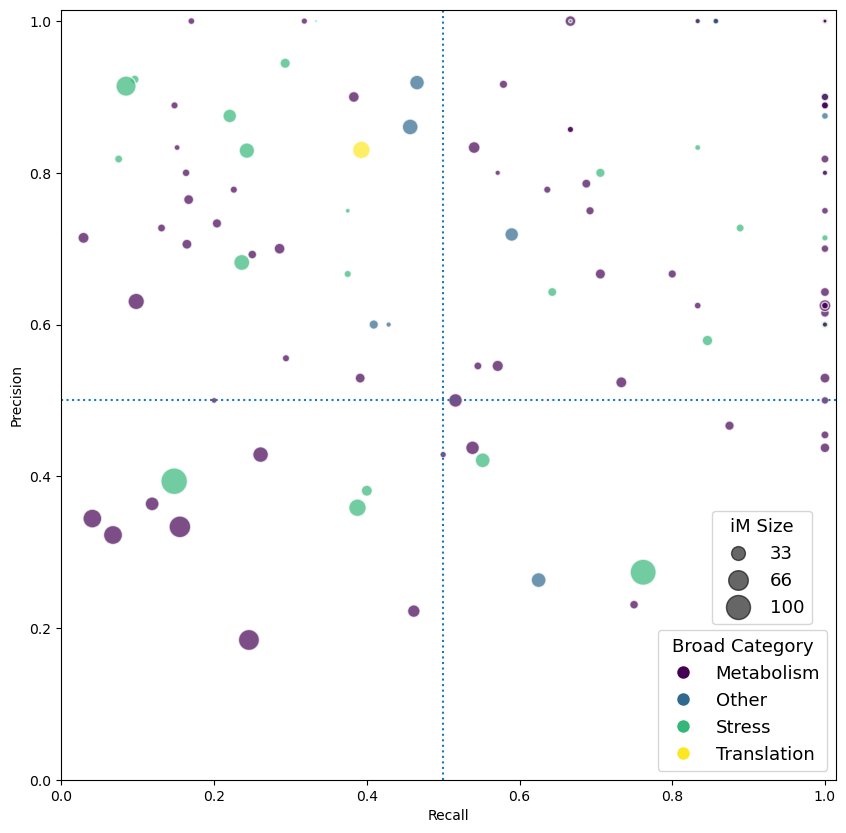

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('white')

# Scatter plot
scatter = ax.scatter(
    imodulon_table['recall'], 
    imodulon_table['precision'], 
    c=imodulon_table['broad_category'].astype('category').cat.codes,  # Color by category
    s=imodulon_table['n_genes'] * 3,  # Size by number of genes
    cmap='viridis',  # Choose a colormap
    alpha=0.7,       # Transparency
    edgecolor='w'    # White edge for better visibility
)

# Create a custom legend for the size with fewer levels
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=4)  # Adjust 'num' for fewer levels

# Divide the size values in the legend by 3
labels = [f"{int(int(label.split('{')[1].split('}')[0]) / 3)}" for label in labels]

# Create the legend for sizes
legend2 = ax.legend(
    handles, 
    labels, 
    title="iM Size", 
    loc="lower right", 
    frameon=True,
    fontsize=13,  # Make the legend text bigger
    title_fontsize=13,  # Make the title font size bigger
    bbox_to_anchor=[.98,.19]
)
ax.add_artist(legend2)

# Create a legend for the color categories
unique_categories = imodulon_table['broad_category'].astype('category').cat.categories
colors = [scatter.cmap(scatter.norm(i)) for i in range(len(unique_categories))]

# Create handles for color legend
color_handles = [plt.Line2D([0], [0], marker='o', color='w', label=category, 
                             markerfacecolor=color, markersize=10) 
                 for category, color in zip(unique_categories, colors)]

# Add the color legend to the plot
ax.legend(handles=color_handles, title="Broad Category", loc="lower right", 
          frameon=True, fontsize=13, title_fontsize=13, )

# Set axis labels
ax.set_xlim([0, 1.015])
ax.set_ylim([0, 1.015])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

# plot lines to break the plot into quadrants
ax.axvline(.5, linestyle='dotted')
ax.axhline(.5, linestyle='dotted')

# Show the plot
plt.show()


In [8]:
imodulon_table

,k,regulator_readable,function,category,n_genes,exp_var,precision,recall,category_num,broad_category
name,,,,,,,,,,
Sugar Diacid,0,CdaR,Transport and catabolism of carbohydrate diaci...,Carbon Metabolism,14,0.002413,0.642857,1.000000,0,Metabolism
Translation,1,DksA,Ribosome biogenesis,Translation,53,0.007469,0.830189,0.392857,1,Translation
ygdT,2,NaN,Unknown,Unknown,3,0.000344,NaN,NaN,2,Other
OxyR,3,OxyR,"Oxidative stress response, especially peroxide",Redox Stress,38,0.001747,0.421053,0.551724,3,Stress
FlhDC-2,4,FlhDC,Flagellum biosynthesis and export,Extracellular Structures,43,0.030021,0.860465,0.456790,4,Other
...,...,...,...,...,...,...,...,...,...,...
Glyoxylate,196,Crp and ArcA and ppGpp and Cra and IclR and IHF,Glyxoylate cycle; alternate to TCA cycle,Energy Metabolism,3,0.002085,1.000000,1.000000,196,Metabolism
CCK-PGI Del,197,NaN,Unknown,Unknown,15,0.000745,NaN,NaN,197,Other
Acetate,198,NaN,Acetate uptake and catabolism; aldehyde catabo...,Carbon Metabolism,7,0.006191,NaN,NaN,198,Metabolism


In [9]:
imodulon_table.regulator_readable.dropna().apply(lambda x: re.split(' and | or ', x)).loc['Zinc-1']

['Zur', 'ZntR', 'CueR']

In [10]:
trn_matrix = pd.crosstab(trn_p1k.gene_id, trn_p1k.regulator).reindex(p1k_X.index).fillna(0)
trn_matrix[['Crp', 'ArcA', 'ppGpp', 'Cra', 'IclR', 'IHF']].sum(axis=1).sort_values().tail(20)

b0429    3.0
b0430    3.0
b0431    3.0
b3368    3.0
b0728    3.0
b0729    3.0
b0726    3.0
b0118    3.0
b0727    3.0
b3574    4.0
b4376    4.0
b1039    4.0
b1037    4.0
b0720    4.0
b1040    4.0
b1038    4.0
b1276    4.0
b4016    6.0
b4015    6.0
b4014    6.0
dtype: float64

In [11]:
trn_matrix[['Zur', 'ZntR', 'CueR']].sum()

regulator
Zur     7.0
ZntR    1.0
CueR    7.0
dtype: float64

In [12]:
regulation_information = pd.DataFrame(columns=['precision', 'recall', 'reg', 'reg_size', 'im_size'])
for im in imodulon_table.dropna().index:
    gene_list = p1k_gene_presence.loc[:,im]
    gene_list = list(gene_list[gene_list > 0].index)
    regulon = imodulon_table.loc[im].regulator_readable.replace(' or ', '/').replace(' and ', '+')
    regulon_size = len(parse_regulon_str(regulon, trn_p1k))
    enrichment = compute_regulon_enrichment(gene_list, regulon, list(p1k_X.index), trn_p1k)[['precision', 'recall']]
    regulation_information.loc[im] = [enrichment['precision'], enrichment['recall'], regulon, int(regulon_size), len(gene_list)]
regulation_information['category'] = imodulon_table.dropna().broad_category

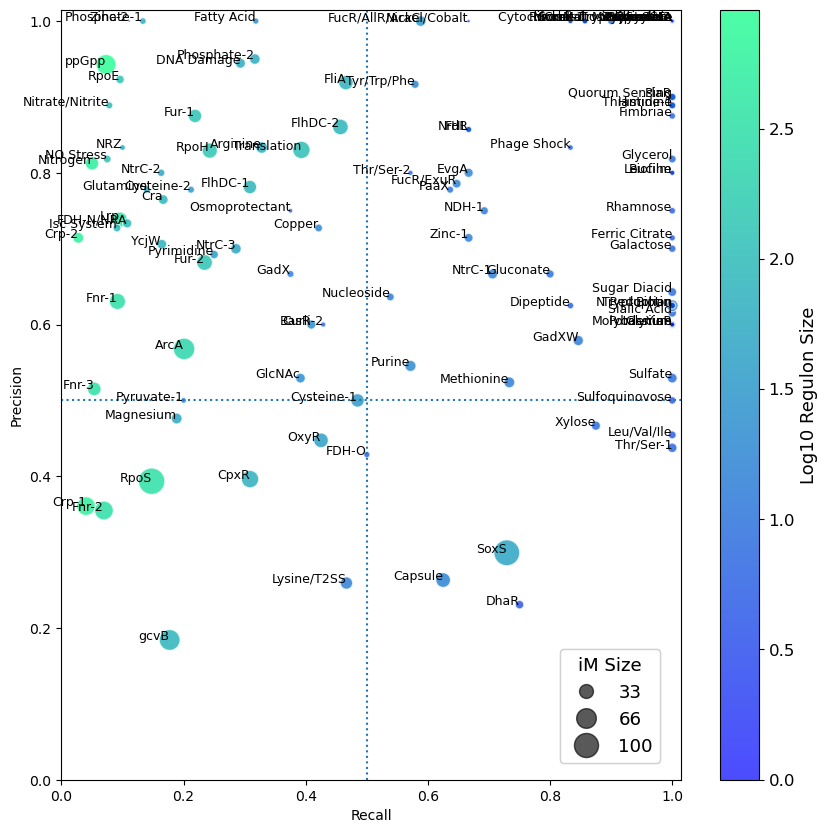

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'regulation_information' DataFrame is already defined

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('white')

# Scatter plot
scatter = ax.scatter(
    regulation_information['recall'], 
    regulation_information['precision'], 
    c=regulation_information['reg_size'].apply(lambda x: np.log10(x)),  # Color by reg_size
    s=regulation_information['im_size'].astype(int) * 3,  # Size by im_size
    cmap='winter',  # Choose a colormap
    alpha=0.7,       # Transparency
    edgecolor='w'    # White edge for better visibility
)

# Create a custom legend for the size with fewer levels
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=4)  # Adjust 'num' for fewer levels

# Divide the size values in the legend by 3
labels = [f"{int(int(label.split('{')[1].split('}')[0]) / 3)}" for label in labels]

# Create the legend for sizes
legend2 = ax.legend(
    handles, 
    labels, 
    title="iM Size", 
    loc="lower right", 
    frameon=True,
    fontsize=13,  # Make the legend text bigger
    title_fontsize=13,  # Make the title font size bigger
    bbox_to_anchor=[.98, .01],
)

ax.add_artist(legend2)

# Create a colorbar for im_size
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Log10 Regulon Size', fontsize=13)
cbar.ax.tick_params(labelsize=12)  # Adjust colorbar tick size

# Set axis labels
ax.set_xlim([0, 1.015])
ax.set_ylim([0, 1.015])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

# Plot dotted lines
ax.axvline(.5, 0, linestyle='dotted')
ax.axhline(.5, 0, linestyle='dotted')

# Label each point with its index
for i, row in regulation_information.iterrows():
    ax.text(row['recall'], row['precision'], str(i), fontsize=9, ha='right')

plt.show()


In [14]:
regulation_information.loc['gcvB']

precision      0.184211
recall         0.177215
reg                gcvB
reg_size             79
im_size              76
category     Metabolism
Name: gcvB, dtype: object

In [24]:
regulation_information

,precision,recall,reg,reg_size,im_size,category,mean_regs_per_gene
Sugar Diacid,0.642857,1.000000,CdaR,9,14,Metabolism,2.571429
Translation,0.830189,0.392857,DksA,112,53,Translation,4.245283
OxyR,0.447368,0.425000,OxyR,40,38,Stress,4.026316
FlhDC-2,0.860465,0.456790,FlhDC,81,43,Other,4.209302
Osmoprotectant,0.750000,0.375000,RpoS+ppGpp+IHF+H-NS,8,4,Stress,4.000000
...,...,...,...,...,...,...,...
gcvB,0.184211,0.177215,gcvB,79,76,Metabolism,0.855263
Glutarate,1.000000,1.000000,RpoS+H-NS+Crp+Lrp+GlaR+ppGpp,5,5,Metabolism,8.000000
Tryptophanase,1.000000,1.000000,Crp+TorR+Nac+L-tryptophan,2,2,Metabolism,5.500000
Phage Shock,0.833333,0.833333,RpoN+IHF+PspF,6,6,Stress,3.666667


In [15]:
for ind in regulation_information.index:
    genes = p1k_gene_presence.loc[:,ind]
    genes  = genes[genes>0].index
    median_regs = (trn_matrix.loc[genes].sum(axis=1).mean())
    regulation_information.loc[ind, 'mean_regs_per_gene'] = median_regs

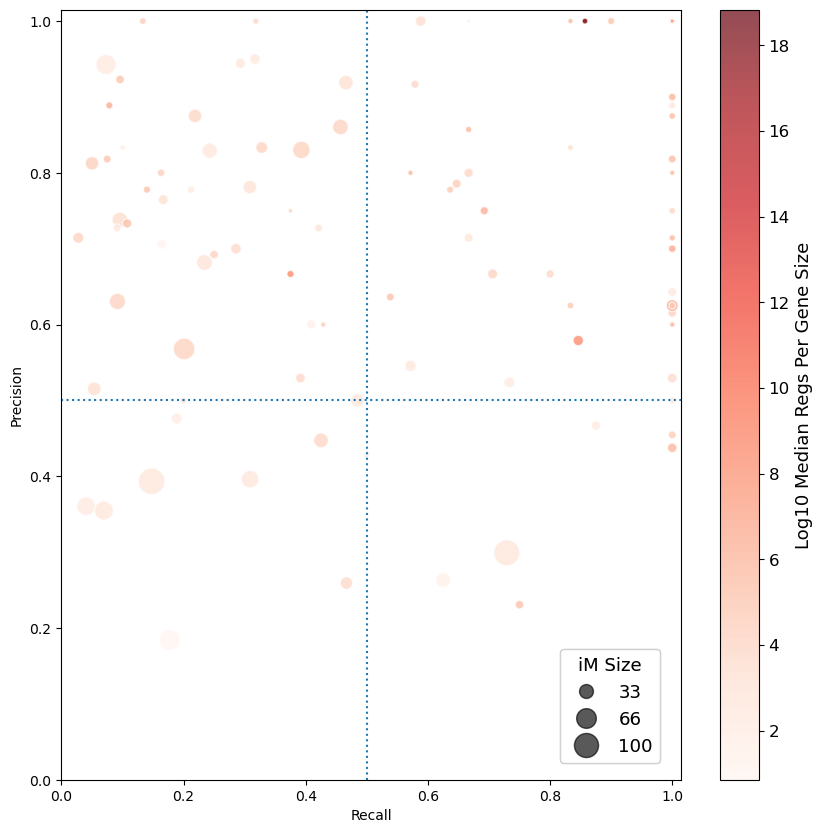

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'regulation_information' DataFrame is already defined

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('white')

# Scatter plot
scatter = ax.scatter(
    regulation_information['recall'], 
    regulation_information['precision'], 
    c=regulation_information['mean_regs_per_gene'].apply(lambda x: 10**np.log10(x)),  # Color by reg_size
    s=regulation_information['im_size'].astype(int) * 3,  # Size by im_size
    cmap='Reds',  # Choose a colormap
    alpha=0.7,       # Transparency
    edgecolor='w'    # White edge for better visibility
)

# Create a custom legend for the size with fewer levels
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=4)  # Adjust 'num' for fewer levels

# Divide the size values in the legend by 3
labels = [f"{int(int(label.split('{')[1].split('}')[0]) / 3)}" for label in labels]

# Create the legend for sizes
legend2 = ax.legend(
    handles, 
    labels, 
    title="iM Size", 
    loc="lower right", 
    frameon=True,
    fontsize=13,  # Make the legend text bigger
    title_fontsize=13,  # Make the title font size bigger
    bbox_to_anchor=[.98, .01],
)

ax.add_artist(legend2)

# Create a colorbar for im_size
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Log10 Median Regs Per Gene Size', fontsize=13)
cbar.ax.tick_params(labelsize=12)  # Adjust colorbar tick size

# Set axis labels
ax.set_xlim([0, 1.015])
ax.set_ylim([0, 1.015])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

# Plot dotted lines
ax.axvline(.5, 0, linestyle='dotted')
ax.axhline(.5, 0, linestyle='dotted')

# # Label each point with its index
# for i, row in regulation_information.iterrows():
#     ax.text(row['recall'], row['precision'], str(i), fontsize=9, ha='right')

plt.show()


In [17]:
regulation_information[regulation_information.reg == 'SoxS']

,precision,recall,reg,reg_size,im_size,category,mean_regs_per_gene
SoxS,0.299145,0.729167,SoxS,48,117,Stress,2.82906


In [18]:
ims_and_regs = pd.DataFrame(columns=['iM', 'reg', 'corr_nca', 'corr_dc', 'overlap_coeff', 'dice_coeff', 'jaccard_coeff'])
for im in regulation_information[regulation_information.precision > .1].index:
    regulators = re.split('\+|\/', regulation_information.loc[im, 'reg'])
    genes = p1k_gene_presence.loc[:,im]
    genes  = genes[genes>0].index
    for reg in regulators:
        reg_genes = trn_matrix[reg]
        reg_genes = reg_genes[reg_genes > 0].index
        if reg in NCA_A.index:
            overlap_coeff = len(set(genes).intersection(set(reg_genes)))/min(len(set(genes)), len(set(reg_genes)))
            dice_coeff = 2*len(set(genes).intersection(set(reg_genes)))/(len(set(genes)) + len(set(reg_genes)))
            jaccard_coeff = len(set(genes).intersection(set(reg_genes)))/len(set(genes).union(set(reg_genes)))
            ims_and_regs.loc[len(ims_and_regs)] = [im, reg, abs(np.corrcoef(p1k_A.loc[im], NCA_A.loc[reg])[0][1]), abs(np.corrcoef(p1k_A.loc[im], dc_A.loc[reg])[0][1]), 
                                                   overlap_coeff, dice_coeff, jaccard_coeff]

In [19]:
ims_and_regs['agreement'] = ims_and_regs.apply(lambda x: (x.corr_nca > .5) and (x.corr_dc > .5), axis=1)
ims_and_regs.groupby('iM').max()

,reg,corr_nca,corr_dc,overlap_coeff,dice_coeff,jaccard_coeff,agreement
iM,,,,,,,
ArcA,ArcA,0.914306,0.850352,0.567901,0.296774,0.174242,True
Arginine,ArgR,0.912574,0.897906,0.833333,0.470588,0.307692,True
BasR,BasR,0.001389,0.687875,0.600000,0.486486,0.321429,False
Biofilm,RpoS,0.863134,0.978545,1.000000,0.888889,0.800000,True
Biotin,BirA,0.974142,0.966260,1.000000,0.769231,0.625000,True
...,...,...,...,...,...,...,...
Tyr/Trp/Phe,TyrR,0.871383,0.904090,0.583333,0.583333,0.411765,True
Xylose,XylR,0.977983,0.974805,0.875000,0.608696,0.437500,True
YcjW,YcjW,0.919780,0.834399,0.705882,0.266667,0.153846,True


In [20]:
np.corrcoef(ims_and_regs.groupby('iM').max().overlap_coeff, regulation_information.loc[ims_and_regs.groupby('iM').mean().index, 'precision'])[0,1]

0.6318925719126476

In [21]:
ims_and_regs[ims_and_regs.reg == 'SoxS']

,iM,reg,corr_nca,corr_dc,overlap_coeff,dice_coeff,jaccard_coeff,agreement
24,SoxS,SoxS,0.728324,0.9066,0.729167,0.424242,0.269231,True


In [22]:
imodulon_table.dropna()[imodulon_table.dropna().regulator_readable.str.contains('SoxS')]

,k,regulator_readable,function,category,n_genes,exp_var,precision,recall,category_num,broad_category
name,,,,,,,,,,
SoxS,22,SoxS,"Superoxide/nitric oxide sensing and removal, p...",Redox Stress,117,0.004168,0.273504,0.761905,22,Stress


In [47]:
plt.style.use('default')

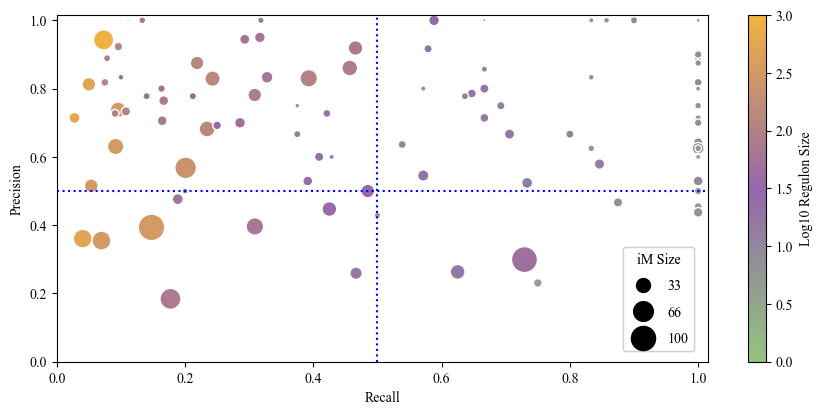

In [69]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import numpy as np

# Assuming 'regulation_information' DataFrame is already defined

# Use the specified font
font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
font_prop = fm.FontProperties(fname=font_path)

# Create a custom colormap using the provided colors
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "custom_colormap", ["#94c47d", "#9367ac", "#f2b340"]
)

# Ensure the normalization matches the data without boundaries
norm = mpl.colors.Normalize(vmin=0, vmax=3)  # Normalize for log10 scale (0 to 3)

fig, ax = plt.subplots(figsize=(10.5, 4.5))
ax.set_facecolor('white')

# Scatter plot with the new colormap and correct normalization
scatter = ax.scatter(
    regulation_information['recall'], 
    regulation_information['precision'], 
    c=regulation_information['reg_size'].apply(lambda x: np.log10(x)),  # Color by log10(reg_size)
    s=regulation_information['im_size'].astype(int) * 3,  # Size by im_size
    cmap=cmap,  # Use the custom colormap
    norm=norm,  # Continuous normalization
    alpha=1.0,  # Full opacity
    edgecolor='w'  # White edge for better visibility
)

# Create a custom legend for iM Size with adjusted spacing
handles, labels = scatter.legend_elements(
    prop="sizes", alpha=1.0, num=4  # Control legend size steps
)

# Adjust the size values in the legend
labels = [f"{int(int(label.split('{')[1].split('}')[0]) / 3)}" for label in labels]

# Configure the legend to use Times New Roman font and proper alignment
legend2 = ax.legend(
    handles, 
    labels, 
    title="iM Size", 
    loc="lower right", 
    frameon=True, 
    fontsize=15,  # Adjust text size in legend
    title_fontsize=15,  # Adjust legend title size
    bbox_to_anchor=[0.99, 0.01],  # Adjust position to prevent overlap
    labelspacing=0.9,  # Increase spacing between circles
    prop=font_prop  # Apply Times New Roman font to labels
)

# Ensure the legend title uses the correct font
legend2.get_title().set_fontproperties(font_prop)

# Add the legend to the plot
ax.add_artist(legend2)

# Create a continuous colorbar with the correct normalization
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')  # Continuous colorbar
cbar.set_label('Log10 Regulon Size', fontsize=10, fontproperties=font_prop)  # Use Times New Roman for the label

# Ensure the colorbar tick labels use Times New Roman font
cbar.ax.tick_params(labelsize=10)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontproperties(font_prop)  # Explicitly apply the font

# Force a redraw of the figure to ensure font updates take effect
plt.draw()

# Set the axis labels and limits with Times New Roman font
ax.set_xlim([0, 1.015])
ax.set_ylim([0, 1.015])
ax.set_xlabel('Recall', fontproperties=font_prop, fontsize=10)
ax.set_ylabel('Precision', fontproperties=font_prop, fontsize=10)

# Add dotted lines for the grid
ax.axvline(0.5, linestyle='dotted', color='b')
ax.axhline(0.5, linestyle='dotted', color='b')

# Use Times New Roman font for the axis tick labels
ax.tick_params(axis='both', which='major', labelsize=10)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontproperties(font_prop)

# Save the plot as an SVG file
plt.savefig('regulator_precision_recall.svg', format='svg')

# Display the plot
plt.show()
